# HF Casual Language Model Benchmark with Module Injection (FSDP)

Highlights:
- Singe instance multiple GPUs with FSDP ZeRO-3.
- Inject modules during model initialization.


In this benchmark, we benchmark the effectiveness of PyTorch custom modules using HuggingFace CLM (e.g., GPT) models on a NVIDIA V100 GPU. The efficient PyTorch custom modules are injected to HF models automatically with EPOI provided injection policies.

## Setup

In [1]:
from IPython.display import clear_output
import os
import torch

# Install dependencies
!pip install datasets evaluate accelerate psutil pybind11 huggingface_hub

clear_output()

We use the following patch to retrieve benchmark metrics (e.g., latency and memory consumption).

In [2]:
!git clone https://github.com/huggingface/transformers || true
!cd transformers; git reset origin/main --hard; git checkout 12ce2941c7b67c0dedac0f0468b3ed854fa940ab
clear_output()

# Note that this patch is generated with transformers commit
# 801ebd045d4310fef2e837713fa630cb183f0104 @ Mon Sep 19 16:55:50 2022 -0400
with open("transformers/benchmark.patch", "w") as f:
    f.write('''
diff --git a/examples/pytorch/language-modeling/run_clm_no_trainer.py b/examples/pytorch/language-modeling/run_clm_no_trainer.py
index d22fa4a49..182337be2 100755
--- a/examples/pytorch/language-modeling/run_clm_no_trainer.py
+++ b/examples/pytorch/language-modeling/run_clm_no_trainer.py
@@ -22,6 +22,7 @@ https://huggingface.co/models?filter=text-generation
 """
 # You can also adapt this script on your own causal language modeling task. Pointers for this are left as comments.

+import time
 import argparse
 import json
 import logging
@@ -66,6 +67,21 @@ require_version("datasets>=1.8.0", "To fix: pip install -r examples/pytorch/lang
 MODEL_CONFIG_CLASSES = list(MODEL_MAPPING.keys())
 MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

+class MemoryTracker:
+    def __init__(self):
+        self.start_memory = 0
+
+    def start(self):
+        import torch
+        import gc
+        gc.collect()
+        torch.cuda.empty_cache()
+        torch.cuda.reset_peak_memory_stats()
+        self.start_memory = torch.cuda.max_memory_allocated()
+
+    def stop_and_log(self, metrics):
+        usage = torch.cuda.max_memory_allocated() - self.start_memory
+        metrics["memory_usage"].append(usage)

 def parse_args():
     parser = argparse.ArgumentParser(description="Finetune a transformers model on a causal language modeling task")
@@ -562,6 +578,9 @@ def main():
     progress_bar.update(starting_epoch * num_update_steps_per_epoch)
     completed_steps = starting_epoch * num_update_steps_per_epoch

+    metrics = {"step_time": [], "memory_usage": []}
+    mem_tracker = MemoryTracker()
+    mem_tracker.start()
     for epoch in range(starting_epoch, args.num_train_epochs):
         model.train()
         if args.with_tracking:
@@ -575,6 +594,7 @@ def main():
                         completed_steps += 1
                     continue

+            start = time.time()
             with accelerator.accumulate(model):
                 outputs = model(**batch)
                 loss = outputs.loss
@@ -597,6 +617,7 @@ def main():
                     if args.output_dir is not None:
                         output_dir = os.path.join(args.output_dir, output_dir)
                     accelerator.save_state(output_dir)
+            metrics["step_time"].append(time.time() - start)
             if completed_steps >= args.max_train_steps:
                 break

@@ -648,6 +669,9 @@ def main():
                 output_dir = os.path.join(args.output_dir, output_dir)
             accelerator.save_state(output_dir)

+    mem_tracker.stop_and_log(metrics)
+    logger.info(metrics)
+
     if args.with_tracking:
         accelerator.end_training()


''')

!cd transformers; git apply benchmark.patch; rm benchmark.patch; git diff examples/pytorch/language-modeling/run_clm_no_trainer.py
!cd transformers; git commit -am "temp"

# Install the changed transformers without checking dependencies (otherwise it may ruin your PyTorch setting...)
#!cd transformers; pip install -e ".[dev]" --no-deps

diff --git a/examples/pytorch/language-modeling/run_clm_no_trainer.py b/examples/pytorch/language-modeling/run_clm_no_trainer.py
index d22fa4a49..182337be2 100755
--- a/examples/pytorch/language-modeling/run_clm_no_trainer.py
+++ b/examples/pytorch/language-modeling/run_clm_no_trainer.py
@@ -22,6 +22,7 @@ https://huggingface.co/models?filter=text-generation
 """
 # You can also adapt this script on your own causal language modeling task. Pointers for this are left as comments.
 
+import time
 import argparse
 import json
 import logging
@@ -66,6 +67,21 @@ require_version("datasets>=1.8.0", "To fix: pip install -r examples/pytorch/lang
 MODEL_CONFIG_CLASSES = list(MODEL_MAPPING.keys())
 MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)
 
+class MemoryTracker:
+    def __init__(self):
+        self.start_memory = 0
+
+    def start(self):
+        import torch
+        import gc
+        gc.collect()
+        torch.cuda.empty_cache()
+        torch.cuda.reset_peak_mem

In [3]:
# Note that we have to use this or later commit to workaround a bug in PyTorch 1.13.0.
# See https://github.com/huggingface/accelerate/pull/803
!git clone https://github.com/huggingface/accelerate || true
!cd accelerate; git reset origin/main --hard; git checkout b816e258a95904736c8e3a5a2b14a18d5f407f4a
clear_output()

In [4]:
# Whether to dump all plotted figures to PDF files.
dump_fig_to_pdf = False

# Log environments
print(f'Pytorch version     :', torch.__version__)
print(f'PyTorch CUDA version:', torch.version.cuda)
for i in range(torch.cuda.device_count()):
    print(f'GPU{i}\t:',torch.cuda.get_device_name(i))

# Log configs.
print()
print(f'{"dump-to-file":14s}: {dump_fig_to_pdf}')

Pytorch version     : 1.13.0+cu117
PyTorch CUDA version: 11.7
GPU0	: Tesla V100-SXM2-16GB
GPU1	: Tesla V100-SXM2-16GB
GPU2	: Tesla V100-SXM2-16GB
GPU3	: Tesla V100-SXM2-16GB
GPU4	: Tesla V100-SXM2-16GB
GPU5	: Tesla V100-SXM2-16GB
GPU6	: Tesla V100-SXM2-16GB
GPU7	: Tesla V100-SXM2-16GB

dump-to-file  : False


## Benchmark Scripts

In [5]:
import os
import re
import json

import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from transformers import AutoConfig, PretrainedConfig

@dataclass
class Exp:
    name: str           # Experiment name
    model: str          # huggingface model name
    block_name: str     # transformer block name (e.g., GPT2Block)
    batch_size: int     # batch size per GPU
    seq_len: int = None # input sequence length
        
    ## Improve speed / reduce memory  
    bf16: bool = False  # Faster, less memory. Recommend if GPU supports
    fp16: bool = False  # Faster, less memory, but need to scale loos. 
                        # Recommend if BF16 is not available.
    grad_accum: int = 1      # accumulate gradients for better performance
    steps: int = 20          # number of parameter updates

    ## Multi-GPUs
    gpus: str = '0'        # GPUs to use. "0,1" means use GPU 0 and 1
    use_fsdp: bool = False # When False, use DeepSpeed

    ## Log
    log_file: str = 'log.txt'
        
    ## kwargs
    kwargs: dict = None
        
    def __post_init__(self):
        model_conf = AutoConfig.from_pretrained(self.model)
        get = lambda *keys: max([getattr(model_conf, k) if hasattr(model_conf, k) else 0 for k in keys])
        self.num_layers = get('num_hidden_layers', 'n_layer')
        self.num_gpus = len(self.gpus.split(','))                      
        self.hidden_size = get('hidden_size', 'n_embd', 'd_model')
        self.vocab_size = get('vocab_size')
        self.num_heads = get('num_attention_heads', 'n_head')
        if self.seq_len is None:
            self.seq_len = get('max_position_embeddings', 'n_ctx')
        n, h, s, v = self.num_layers, self.hidden_size, self.seq_len, self.vocab_size
        att, ffn, embed = 4*h*s**2 + 8*s*h**2, 16*s*h**2, 2*s*h*v
        forward = n*(att+ffn) + embed
        # TFLOPs to train one example
        self.tflops = (3 * forward) / 1e12
        self.launcher = 'accelerate launch'
            
    def print_results(self):
        print(f'Engine: {"FSDP" if self.use_fsdp else "DeepSpeed"}')
        print('Total samples / second\t: %.1f' % self.samples_per_sec)
        print('Per GPU memory (GB)\t: %.1f'% self.gpu_mem)
        print('Per GPU TFLOPs\t\t: %.1f' % (self.samples_per_sec * self.tflops / self.num_gpus))

In [6]:
%config InlineBackend.figure_formats = ['svg']

def compare(exps, save_to=""):
    fig, ax = plt.subplots(ncols=3, figsize=(9,len(exps)/2))
    x = list(range(len(exps)))
    for i, (y, l) in enumerate((
        ([e.samples_per_sec for e in exps], 'Samples / sec'), 
        ([e.samples_per_sec * e.tflops / e.num_gpus for e in exps], 'per GPU TFLOPS'),
        ([e.gpu_mem for e in exps], 'per GPU memory (GB)'))):
        print(f"{l}: {['%.2f' % e for e in y]}")
        ax[i].barh(x, y, align='center', height=0.6, color=plt.get_cmap('Set1')(x))
        ax[i].invert_yaxis()
        ax[i].set_xlabel(l)
        if i == 0:
            ax[i].set_yticks(x, labels=[e.name for e in exps])
        else:
            ax[i].set_yticklabels([])

    if save_to:
        plt.savefig(save_to, bbox_inches="tight")
    else:
        plt.show()

In [7]:
def hf_gpt(exp):
    import json
    if exp.use_fsdp:
        # Generate config file.
        with open("cfg.yaml", "w") as filep:
            filep.write(f"""compute_environment: LOCAL_MACHINE
deepspeed_config: {{}}
distributed_type: FSDP
downcast_bf16: {'yes' if exp.bf16 else 'no'}
fsdp_config:
  fsdp_auto_wrap_policy: TRANSFORMER_BASED_WRAP
  fsdp_transformer_layer_cls_to_wrap: {exp.block_name}
  fsdp_backward_prefetch_policy: NO_PREFETCH
  fsdp_offload_params: true
  fsdp_sharding_strategy: 1
  fsdp_state_dict_type: SHARDED_STATE_DICT
machine_rank: 0
main_process_ip: null
main_process_port: null
main_training_function: main
mixed_precision: {'fp16' if exp.fp16 else 'no'}
num_machines: 1
num_processes: {len(exp.gpus.split(','))}
rdzv_backend: static
same_network: true
use_cpu: false
            """)
    else:
        # Generate DeepSpeed config file.
        with open("ds_config.json", "w") as filep:
            config = {
                "fp16": {
                    "enabled": exp.fp16,
                },
                "bf16": {
                    "enabled": exp.bf16
                },
                "zero_optimization": {
                    "offload_optimizer": {
                        "device": "cpu",
                        "pin_memory": True
                    },
                    "offload_param": {
                        "device": "cpu",
                        "pin_memory": True
                    },
                    "stage": 3,
                    "overlap_comm": True,
                    "contiguous_gradients": False,
                    "sub_group_size": 1e9,
                    "reduce_bucket_size": "auto",
                    "stage3_prefetch_bucket_size": "auto",
                    "stage3_param_persistence_threshold": "auto",
                    "stage3_max_live_parameters": 1e9,
                    "stage3_max_reuse_distance": 1e9,
                },
                "gradient_accumulation_steps": 1,
                "gradient_clipping": "auto",
                "train_batch_size": "auto",
                "train_micro_batch_size_per_gpu": "auto",
                "wall_clock_breakdown": False
            }
            json.dump(config, filep, indent=2)
        
        # Generate config file.
        with open("cfg.yaml", "w") as filep:
            filep.write(f"""compute_environment: LOCAL_MACHINE
compute_environment: LOCAL_MACHINE
deepspeed_config:
  deepspeed_config_file: ds_config.json
  zero3_init_flag: true
distributed_type: DEEPSPEED
downcast_bf16: 'no'
fsdp_config: {{}}
machine_rank: 0
main_process_ip: null
main_process_port: null
main_training_function: main
mixed_precision: 'no'
num_machines: 1
num_processes: {len(exp.gpus.split(','))}
rdzv_backend: static
same_network: true
use_cpu: false
            """)
    
    # Launch
    cmd = f'''export CUDA_VISIBLE_DEVICES={exp.gpus}; \
{exp.launcher} --config_file cfg.yaml \
transformers/examples/pytorch/language-modeling/run_clm_no_trainer.py \
--dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 \
--block_size {exp.seq_len} --overwrite_cache --output_dir /tmp/gpt \
--model_name_or_path {exp.model} --tokenizer_name {exp.model} \
--per_device_train_batch_size {exp.batch_size} \
--max_train_steps {exp.steps} --learning_rate 2e-5 \
--gradient_accumulation_steps {exp.grad_accum}'''
    cmd += f' > {exp.log_file} 2>&1'
    print(cmd)
    os.system(cmd)
    ret = hf_log(exp, exp.log_file)
    if ret is not None:
        ret.print_results()
    return ret

    
def hf_log(exp, log_filename):
    import re
    import json
    with open(log_filename) as f:
        lines = f.readlines()
        
    global_batch_size = 0
    dedup = set()
    for l in lines:
        tokens = re.findall(r'(Apply .*? for .*? times)', l)
        l = l.replace("\n", "")
        for token in tokens:
            if token not in dedup:
                print(token)
                dedup.add(token)
        if 'CUDA out of memory' in l:
            print('Out of GPU memory, try a smaller batch size')
            return None
        if 'Total train batch size' in l:
            global_batch_size = int(next(iter(reversed(re.findall('= +([\d\.]+)', l))), 0))
        if 'step_time' in l:
            if global_batch_size == 0:
                print(f'Failed to parse global batch size. Check {log_filename} to find error')
            # Remove the first 5 iterations (warmup)
            proc_metric = lambda lst: [float(t) for t in (lst[5:] if len(lst) > 5 else lst)]
            metrics = json.loads(l[l.find("{"):].replace('\'', '\"'))
            step_time_list = proc_metric(metrics["step_time"])
            exp.samples_per_sec = (global_batch_size * len(step_time_list)) / sum(step_time_list)
            gpu_mem_list = proc_metric(metrics["memory_usage"])
            exp.gpu_mem = sum(gpu_mem_list) / len(gpu_mem_list) / 1e9
            
            return exp
    print(f'Failed (metrics not found). Check "{log_filename}" to find error')    
    return None

In [8]:
# bs=2 OOM
n_gpu = 8
ds_v1 = hf_gpt(Exp('Vanilla-DS(bs1)', "gpt2-xl", "GPT2Block", 1,
                   gpus=",".join([str(i) for i in range(n_gpu)]),
                   seq_len=1024, fp16=True, use_fsdp=False, log_file="ds.log"))

export CUDA_VISIBLE_DEVICES=0,1,2,3,4,5,6,7; accelerate launch --config_file cfg.yaml transformers/examples/pytorch/language-modeling/run_clm_no_trainer.py --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --block_size 1024 --overwrite_cache --output_dir /tmp/gpt --model_name_or_path gpt2-xl --tokenizer_name gpt2-xl --per_device_train_batch_size 1 --max_train_steps 20 --learning_rate 2e-5 --gradient_accumulation_steps 1 > ds.log 2>&1
Engine: DeepSpeed
Total samples / second	: 2.9
Per GPU memory (GB)	: 13.9
Per GPU TFLOPs		: 3.8


In [10]:
# OOM
# n_gpu = 8
# fsdp_v1 = hf_gpt(Exp('Vanilla-FSDP(bs1)', "gpt2-xl", "GPT2Block", 1,
#                      gpus=",".join([str(i) for i in range(n_gpu)]),
#                      seq_len=1024, fp16=True, use_fsdp=True, log_file="fsdp.log"))

## Setup epoi and xFormers

In [11]:
def build_package(name, url):
    import importlib
    import os, sys
    if importlib.util.find_spec(name) is None:
        os.system(f"git clone {url} {name} || true")
        os.system(f"cd {name}; git submodule update --init --recursive")
        os.system(f"cd {name}; pip3 install -r requirements.txt || true")
        os.system(f'cd {name}; pip3 install -e ".[dev]"') 

build_package("xformers", "https://github.com/facebookresearch/xformers.git")
build_package("epoi", "https://github.com/comaniac/epoi.git")

In [12]:
with open("transformers/patch", "w") as f:
    f.write('''
diff --git a/examples/pytorch/language-modeling/run_clm_no_trainer.py b/examples/pytorch/language-modeling/run_clm_no_trainer.py
index 61fc04906..fa4afb387 100755
--- a/examples/pytorch/language-modeling/run_clm_no_trainer.py
+++ b/examples/pytorch/language-modeling/run_clm_no_trainer.py
@@ -383,6 +383,9 @@ def main():
             "You can do it from another script, save it, and load it from here, using --tokenizer_name."
         )

+    from epoi.inject import InjectModuleContext
+    ctx = InjectModuleContext()
+    ctx.__enter__()
     if args.model_name_or_path:
         model = AutoModelForCausalLM.from_pretrained(
             args.model_name_or_path,
@@ -392,6 +395,7 @@ def main():
     else:
         logger.info("Training new model from scratch")
         model = AutoModelForCausalLM.from_config(config)
+    ctx.__exit__(None, None, None)

     model.resize_token_embeddings(len(tokenizer))

''')

!cd transformers; git apply patch; rm patch; git diff examples/pytorch/language-modeling/run_clm_no_trainer.py

diff --git a/examples/pytorch/language-modeling/run_clm_no_trainer.py b/examples/pytorch/language-modeling/run_clm_no_trainer.py
index 182337be2..25c0752df 100755
--- a/examples/pytorch/language-modeling/run_clm_no_trainer.py
+++ b/examples/pytorch/language-modeling/run_clm_no_trainer.py
@@ -384,6 +384,9 @@ def main():
             "You can do it from another script, save it, and load it from here, using --tokenizer_name."
         )
 
+    from epoi.inject import InjectModuleContext
+    ctx = InjectModuleContext()
+    ctx.__enter__()
     if args.model_name_or_path:
         model = AutoModelForCausalLM.from_pretrained(
             args.model_name_or_path,
@@ -393,6 +396,7 @@ def main():
     else:
         logger.info("Training new model from scratch")
         model = AutoModelForCausalLM.from_config(config)
+    ctx.__exit__(None, None, None)
 
     model.resize_token_embeddings(len(tokenizer))
 


In [13]:
n_gpu = 8
ds_v2 = hf_gpt(Exp('Injected-DS(bs1)', "gpt2-xl", "GPT2Block", 1,
                   gpus=",".join([str(i) for i in range(n_gpu)]),
                   seq_len=1024, fp16=True, use_fsdp=False, log_file="ds-injected.log"))

export CUDA_VISIBLE_DEVICES=0,1,2,3,4,5,6,7; accelerate launch --config_file cfg.yaml transformers/examples/pytorch/language-modeling/run_clm_no_trainer.py --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --block_size 1024 --overwrite_cache --output_dir /tmp/gpt --model_name_or_path gpt2-xl --tokenizer_name gpt2-xl --per_device_train_batch_size 1 --max_train_steps 20 --learning_rate 2e-5 --gradient_accumulation_steps 1 > ds-injected.log 2>&1
Apply GenericSelfAttention for 48 times
Apply FusedMLP for 48 times
Engine: DeepSpeed
Total samples / second	: 3.0
Per GPU memory (GB)	: 10.9
Per GPU TFLOPs		: 3.9


In [14]:
# OOM
# n_gpu = 8
# fsdp_v2 = hf_gpt(Exp('Injected-FSDP(bs1)', "gpt2-xl", "GPT2Block", 1,
#                      gpus=",".join([str(i) for i in range(n_gpu)]),
#                      seq_len=1024, fp16=True, use_fsdp=True, log_file="fsdp-injected.log"))

In [15]:
n_gpu = 8
ds_v3 = hf_gpt(Exp('Injected-DS(bs2)', "gpt2-xl", "GPT2Block", 2,
                   gpus=",".join([str(i) for i in range(n_gpu)]),
                   seq_len=1024, fp16=True, use_fsdp=False, log_file="ds-injected.log"))

export CUDA_VISIBLE_DEVICES=0,1,2,3,4,5,6,7; accelerate launch --config_file cfg.yaml transformers/examples/pytorch/language-modeling/run_clm_no_trainer.py --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --block_size 1024 --overwrite_cache --output_dir /tmp/gpt --model_name_or_path gpt2-xl --tokenizer_name gpt2-xl --per_device_train_batch_size 2 --max_train_steps 20 --learning_rate 2e-5 --gradient_accumulation_steps 1 > ds-injected.log 2>&1
Apply GenericSelfAttention for 48 times
Apply FusedMLP for 48 times
Engine: DeepSpeed
Total samples / second	: 6.2
Per GPU memory (GB)	: 13.4
Per GPU TFLOPs		: 8.2


Samples / sec: ['2.87', '2.98', '6.22']
per GPU TFLOPS: ['3.78', '3.92', '8.18']


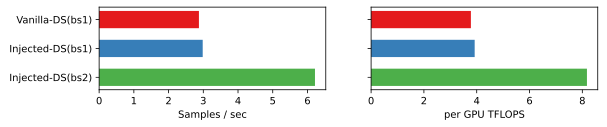

In [16]:
compare([ds_v1, ds_v2, ds_v3], "inject_clm.pdf" if dump_fig_to_pdf else None)